## Fraude Detection 


The aim of this project is to identify the fraudulent credit card transactions. For the credit card companies is important to recognize the fraud cases, so that the customers are not charged for items that they did not purchase.

The dataset used for this project contains transactions made by credit cards in September 2013 by european cardholders.

This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, **the positive class (frauds) account for 0.172% of all transactions.**


It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, it's not possible to have the original features and more background information about the data. 

- Features V1, V2, … V28 are the principal components obtained with PCA, 
- the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 
- The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning.
- Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

**Link for the Dataset** : https://www.kaggle.com/mlg-ulb/creditcardfraud


**Model** : we will use the Random Forest and will compare different technique for the unbalanced data
- Random Forest with Unbalanced Data
- Random Forest with Oversampling technique using SMOTE
- Random Forest with Balanced Data
- Random  with Class Weight adjusted manually

Finally we will compare the result of the Random Forest with another classifier wich is the Logistic Regression

**Evaluation metric:**
Due to the high imbalanced data 0.172% positive class (fraud cases), the accuracy ratio is is not meaningful.

The metric used for this project :
- Recall, precision, F1
- ROC AUC 
- Confusion matrix

These metric will be analyzed for the train and validation database. 
As for the Fradulent case modelling the best model will be the one that have the best Recall and a low rate of valid transaction considered as Fradulent(False Positive) 



## Package

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import tensorflow.keras
import csv
from pathlib import Path

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import recall_score,accuracy_score,f1_score,plot_roc_curve
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
import seaborn as sns
from imblearn.over_sampling import SMOTE
from itertools import product
# Plotting options
%matplotlib inline

np.set_printoptions(precision=3)

sns.set(style='whitegrid')
from time import time
from util_gridsearch import *

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Preparing the DataBase

In [2]:
#read the file
df = pd.read_csv('Data/creditcard.csv')

In [3]:
print("The number of case in the database : ", df.shape[0])
print("The number of columns in the database : ", df.shape[1])

The number of case in the database :  284807
The number of columns in the database :  31


In [4]:
occ=df['Class'].value_counts()
occ
print("The number of non-fraudulent cases : ", occ[0])
print("The number of the fraudulent cases : ", occ[1])

The number of non-fraudulent cases :  284315
The number of the fraudulent cases :  492


In [5]:
# Print the ratio of fraud cases
ratio_cases = occ/len(df.index)
print(f'Ratio of fraudulent cases: {ratio_cases[1]}\nRatio of non-fraudulent cases: {ratio_cases[0]}')

Ratio of fraudulent cases: 0.001727485630620034
Ratio of non-fraudulent cases: 0.9982725143693799


In [6]:
#Check missing values
df.isnull().any().any()

False

In [7]:
#Print of the diffrent statistics
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [8]:
Fraud = df[df['Class'] == 1]
Valid = df[df['Class'] == 0]

print("Fraudulent cases - the details amount")
print("--------------------------------------")
Fraud.Amount.describe()


Fraudulent cases - the details amount
--------------------------------------


count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [9]:
print("The non-fraudulent cases - the details amount")
print("----------------------------------------------")
Valid.Amount.describe()

The non-fraudulent cases - the details amount
----------------------------------------------


count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [10]:
#Convert time in hours
df.loc[:,'Time'] = df.Time / 3600

In [11]:
#Normalization of the amount
df.Amount = StandardScaler().fit_transform(df.Amount.values.reshape(-1, 1))

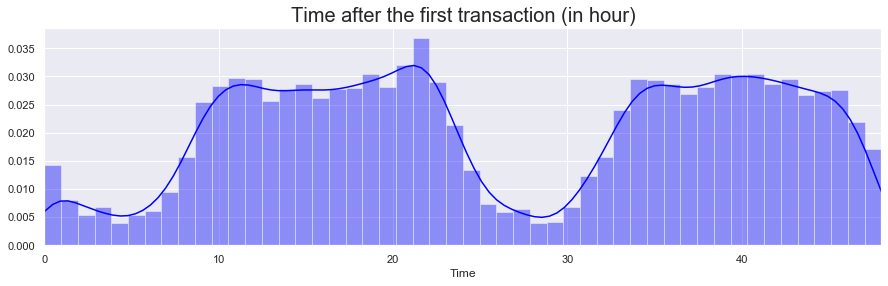

In [12]:
# Distribution of the Time Variable
sns.set(rc={'figure.figsize': (15, 15)})
plt.figure(figsize=(15,4))
fig = sns.distplot(df['Time'], kde=True, color="blue")
plt.xlim([0,48])
plt.title("Time after the first transaction (in hour)",fontsize=20)
plt.show()

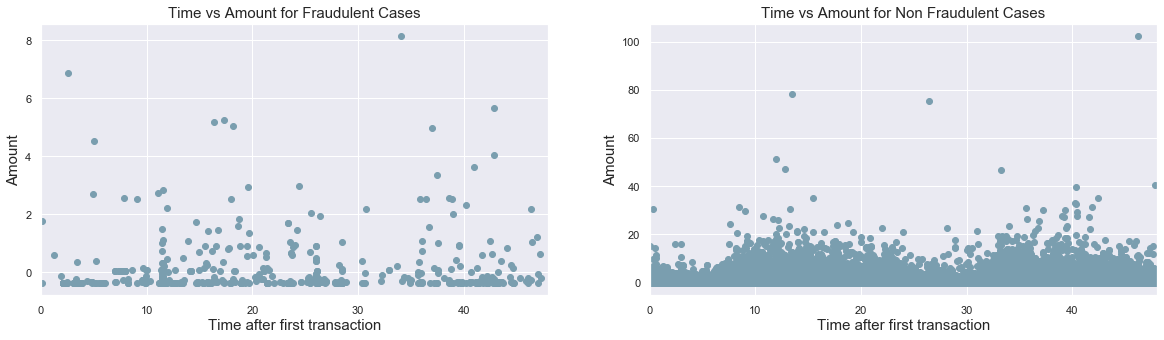

In [13]:
# Time vs Amount in Fraud Cases

sns.set(rc={'figure.figsize': (20, 5)})
plt.subplot(1,2,1)
#plt.figure(figsize=(10,10))
fig = plt.scatter(x=df[df['Class'] == 1]['Time'], y=df[df['Class'] == 1]['Amount'], color="#7a9eaf")
plt.xlabel('Time after first transaction', fontsize=15)
plt.ylabel('Amount', fontsize=15)
plt.title("Time vs Amount for Fraudulent Cases",fontsize=15)
plt.xlim([0,48])
plt.subplot(1,2,2)
#plt.figure(figsize=(10,5))
fig = plt.scatter(x=df[df['Class'] == 0]['Time'], y=df[df['Class'] == 0]['Amount'], color="#7a9eaf")
plt.xlabel('Time after first transaction', fontsize=15)
plt.ylabel('Amount', fontsize=15)
plt.title("Time vs Amount for Non Fraudulent Cases",fontsize=15)
plt.xlim([0,48])
plt.show()

In [14]:
def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    #"""
 #""""   Convert the DataFrame into two variable
 #   X: data columns (V1 - V28)
  #  y: lable column
  # "" """
    X = df.iloc[:, 2:30].values
    y = df.Class.values
    return X, y

In [15]:
# Define a function to create a scatter plot of our data and labels
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 2], X[y == 0, 23], label="Non Fraud", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 2], X[y == 1, 23], label="Fraud", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

In [16]:
# Create X and y from the prep_data function 
X, y = prep_data(df)

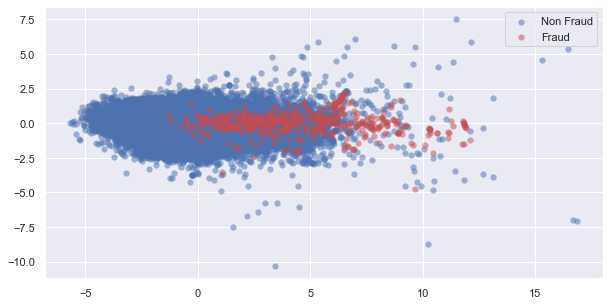

In [17]:
# Plot our data by running our plot data function on X and y
sns.set(rc={'figure.figsize': (10, 5)})
plot_data(X, y)

**By visualizing the data, you can immediately see how our fraud cases are scattered over our data, and how few cases we have.**

In [18]:
# we exclude Class
X = df.iloc[:,:-1]
y = df.Class

In [19]:
X.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475


In [20]:
y.head(2)

0    0
1    0
Name: Class, dtype: int64

## Split of the data

In [21]:
# Split of the data : 20% for the test set and 80% for the training set
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)

## DummyClassifier
DummyClassifier is a classifier that makes predictions using simple rules, which can be useful as a baseline for comparison against actual classifiers, especially with imbalanced classes.

In [22]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score,accuracy_score
    
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
y_dummy_predictions = dummy_majority.predict(X_test)
accuracy_dummy=accuracy_score(y_test, y_dummy_predictions)
recall_dummy=recall_score(y_test, y_dummy_predictions)

print('The Accuracy for the Dummy Classifier %0.4f:'% accuracy_dummy)
print('The recall for the Dummy Classifier  %0.4f:'% recall_dummy)

The Accuracy for the Dummy Classifier 0.9982:
The recall for the Dummy Classifier  0.0000:


**The accuracy ratio** is not meaningful for this case of high unbalanced data

## Random Forest 

**The Random Forest Key parameters :**
- n_estimators: number of trees to use in ensemble (default: 10), should be larger for large Dataset
- max_features: has a strong effect on performance. Influences the diversity of trees in the forest.
- max_depth: controls the depth of each tree (default: None. Splits until all leaves are pure).


The random forest takes much longer to train on this fairly large dataset, so we don't actually do a hyperparameter grid search, only specifiying the key parameters(n_estimators, max_features,max_depth). We'll leave the grid search implemented in case we decide to try different hyperparameter values in the future.

We will use this parametres :
max_depth=6,max_features='auto', n_estimators=100,random_state=0,


- Random Forest with Unbalanced Data
- Random Forest with Oversampling technique using SMOTE
- Random Forest with Balanced Data
- Random  with adjusted Class Weight

## 1- Random Forest - Unbalanced Data

In [23]:
RF_UnBalanced = RandomForestClassifier(max_depth=6,
                               max_features='auto', 
                               n_estimators=100,
                               n_jobs=-1,
                               random_state=0)
# Get results from your model
dict_RF_UNbalanced=get_model_results(X_train, y_train, X_test, y_test, RF_UnBalanced,model_name='RF_UnBalanced')

Model : RF_UnBalanced
-------------------------------------------------------
Accuracy: 0.999
Precision: 0.911
Recall: 0.713
F1: 0.800
The ROC Score = 0.975 

Classification Report - Test set:
-----------------------------------------
              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     56861
       Fraud       0.91      0.71      0.80       101

    accuracy                           1.00     56962
   macro avg       0.96      0.86      0.90     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix in number - Test set:
-----------------------------------------
[[56854     7]
 [   29    72]]

Normalized Confusion Matrix -Test set :
-----------------------------------------
[[ 0.99988  0.00012]
 [ 0.28713  0.71287]]

Classification Report - Training set:
-----------------------------------------
              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00    227454
       Fr

Text(0.5, 1.0, 'ROC Curve- Random Forest UnBalanced')

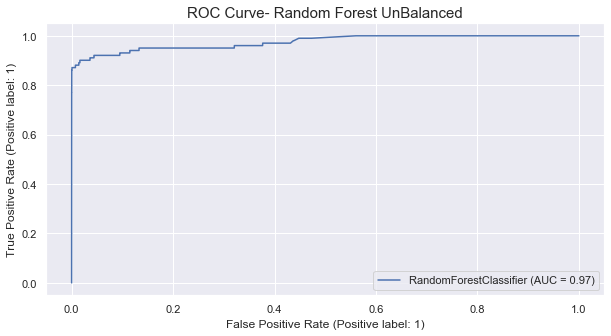

In [24]:
plot_roc_curve(RF_UnBalanced, X_test, y_test)
plt.title("ROC Curve- Random Forest UnBalanced",fontsize=15)

**Comments**


- For the test set, only 7 regular transactions are wrongly predicted as fraudulent, the model detects 71% of the fraudulent transactions. As a consequence 29 fraudulent transactions are not detected (False Negatives).

- Let's see if we can improve this performance using Oversampling technique using SMOTE

## 2- Random Forest - Oversampling technique using SMOTE
(Synthetic Minority Oversample TEchnique)
- The alternative to down-sampling is the upsampling of the minority class to the same level as the dominant one.
- This can be achieved with the SMOTE method where a new vector is generated between 2 existing datapoints. Applying this technique allows to massively increase the number of fraudulent transactions

In [25]:
X_resample, y_resample = SMOTE().fit_resample(X_train,y_train.values.ravel())

In [26]:
print('Number of total transactions before SMOTE upsampling: ', len(y), '...after SMOTE upsampling: ', len(y_resample))
print('Number of fraudulent transactions before SMOTE upsampling: ', len(y_train[y_train==1]), 
      '...after SMOTE upsampling: ', np.sum(y_resample[y_resample==1]))

Number of total transactions before SMOTE upsampling:  284807 ...after SMOTE upsampling:  454908
Number of fraudulent transactions before SMOTE upsampling:  391 ...after SMOTE upsampling:  227454


In [27]:
RF_SMOTE = RandomForestClassifier(max_depth=6,
                               max_features='auto', 
                               n_estimators=100,
                               n_jobs=-1,
                               random_state=0)
# Get results from your model
dict_RF_Smote=get_model_results(X_resample, y_resample, X_test, y_test, RF_SMOTE,model_name='RF_Smote')

Model : RF_Smote
-------------------------------------------------------
Accuracy: 0.997
Precision: 0.404
Recall: 0.871
F1: 0.552
The ROC Score = 0.983 

Classification Report - Test set:
-----------------------------------------
              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     56861
       Fraud       0.40      0.87      0.55       101

    accuracy                           1.00     56962
   macro avg       0.70      0.93      0.78     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix in number - Test set:
-----------------------------------------
[[56731   130]
 [   13    88]]

Normalized Confusion Matrix -Test set :
-----------------------------------------
[[ 0.99771  0.00229]
 [ 0.12871  0.87129]]

Classification Report - Training set:
-----------------------------------------
              precision    recall  f1-score   support

   Non Fraud       0.90      1.00      0.95    227454
       Fraud  

Text(0.5, 1.0, 'ROC Curve- Random Forest SMOTE')

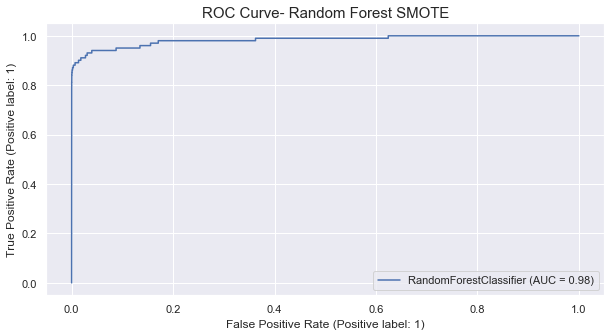

In [28]:
plot_roc_curve(RF_SMOTE, X_test, y_test)
plt.title("ROC Curve- Random Forest SMOTE",fontsize=15)

**Comments**:
 * Using the Oversampling with Smote, we have 78% of the fradulent cases that are detected, but the number of false positive cases increases to 130 cases.


## 3- Random Forest  - Balanced data

In [37]:
RF_Balanced = RandomForestClassifier(class_weight='balanced_subsample', 
                               max_depth=6,
                               max_features='auto', 
                               n_estimators=100,
                               n_jobs=-1,
                               random_state=0)
# Get results from your model
dict_RF_Balanced=get_model_results(X_train, y_train, X_test, y_test, RF_Balanced,model_name='RF_Balanced')

Model : RF_Balanced
-------------------------------------------------------
Accuracy: 0.999
Precision: 0.677
Recall: 0.851
F1: 0.754
The ROC Score = 0.985 

Classification Report - Test set:
-----------------------------------------
              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     56861
       Fraud       0.68      0.85      0.75       101

    accuracy                           1.00     56962
   macro avg       0.84      0.93      0.88     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix in number - Test set:
-----------------------------------------
[[56820    41]
 [   15    86]]

Normalized Confusion Matrix -Test set :
-----------------------------------------
[[ 0.99928  0.00072]
 [ 0.14851  0.85149]]

Classification Report - Training set:
-----------------------------------------
              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00    227454
       Frau

Text(0.5, 1.0, 'ROC Curve- Random Forest Balanced')

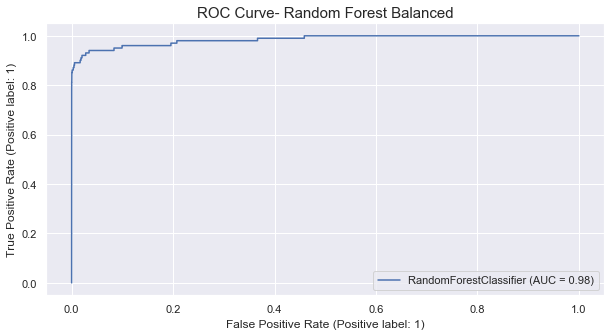

In [38]:
plot_roc_curve(RF_Balanced, X_test, y_test)
plt.title("ROC Curve- Random Forest Balanced",fontsize=15)

**Comments**
 
 * With Balanced data, the model detects 86% of the fraud case and reduce the number of false positive to 0.12%  
 


## 3- Manual Adjusted weight (class_weight) :1:230
the positive class is adjusted to 40% of the dataset

In [31]:
RF_ManualWeight = RandomForestClassifier(class_weight={0: 1, 1: 230}, 
                               max_depth=6,
                               max_features='auto', 
                               n_estimators=100,
                               n_jobs=-1,
                               random_state=0)
# Get results from your model
dict_RF_ManualWeight=get_model_results(X_train, y_train, X_test, y_test,RF_ManualWeight,model_name='RF_ManualWeight')

Model : RF_ManualWeight
-------------------------------------------------------
Accuracy: 0.999
Precision: 0.796
Recall: 0.851
F1: 0.823
The ROC Score = 0.985 

Classification Report - Test set:
-----------------------------------------
              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     56861
       Fraud       0.80      0.85      0.82       101

    accuracy                           1.00     56962
   macro avg       0.90      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix in number - Test set:
-----------------------------------------
[[56839    22]
 [   15    86]]

Normalized Confusion Matrix -Test set :
-----------------------------------------
[[ 0.99961  0.00039]
 [ 0.14851  0.85149]]

Classification Report - Training set:
-----------------------------------------
              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00    227454
       

Text(0.5, 1.0, 'ROC Curve- RandomForest Manual Weight Adjusted')

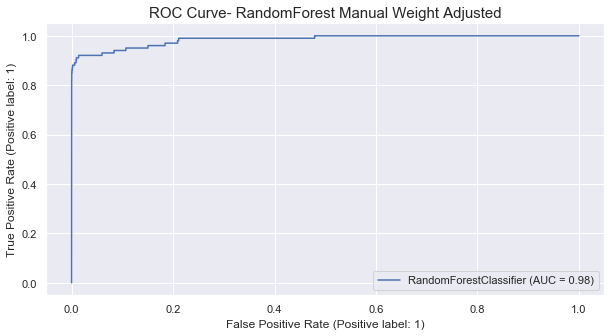

In [32]:
ROC_RF_Weight = plot_roc_curve(RF_ManualWeight, X_test, y_test)
plt.title("ROC Curve- RandomForest Manual Weight Adjusted",fontsize=15)

**Comments**
 
 * Only 14% of Fradulent cases were not detected, and the ratio of the false positive is 0.04%


## 4- LogisticRegression - Balanced data

Let's try the Logistic Regression with Default parameters and Class_weight='balanced'

In [34]:
model_LR = LogisticRegression(class_weight='balanced',random_state=0)
dict_LR_Balanced=get_model_results(X_train, y_train, X_test, y_test, model_LR,model_name='LR_Balanced')

Model : LR_Balanced
-------------------------------------------------------
Accuracy: 0.977
Precision: 0.067
Recall: 0.941
F1: 0.126
The ROC Score = 0.986 

Classification Report - Test set:
-----------------------------------------
              precision    recall  f1-score   support

   Non Fraud       1.00      0.98      0.99     56861
       Fraud       0.07      0.94      0.13       101

    accuracy                           0.98     56962
   macro avg       0.53      0.96      0.56     56962
weighted avg       1.00      0.98      0.99     56962


Confusion Matrix in number - Test set:
-----------------------------------------
[[55548  1313]
 [    6    95]]

Normalized Confusion Matrix -Test set :
-----------------------------------------
[[ 0.97691  0.02309]
 [ 0.05941  0.94059]]

Classification Report - Training set:
-----------------------------------------
              precision    recall  f1-score   support

   Non Fraud       1.00      0.98      0.99    227454
       Frau

Text(0.5, 1.0, 'ROC Curve- Logistic Regression Balanced')

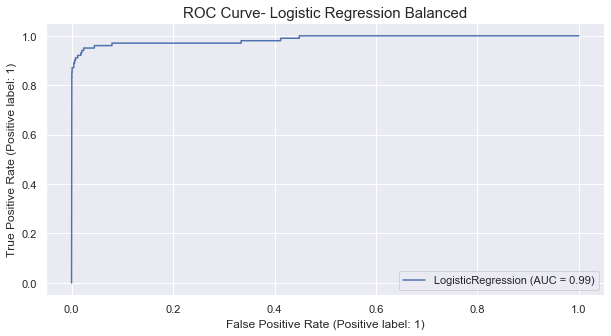

In [35]:
plot_roc_curve(model_LR, X_test, y_test)
plt.title("ROC Curve- Logistic Regression Balanced",fontsize=15)

**Comments**

The Logistic regression increases the number of the false positive 2.3% (1313) which is very high, given the high number of transactions, and detected 94% of fradulent case

## 5- Conclusion 

In [36]:
#results in a DataFrame
keys = dict_RF_UNbalanced.keys()
d_merged = {k: [dict_RF_UNbalanced.get(k), dict_RF_Smote.get(k),
                dict_RF_Balanced.get(k),dict_RF_ManualWeight.get(k),dict_LR_Balanced.get(k)] for k in keys}
result=pd.DataFrame(d_merged)
result

,Model,Recall,Precision,F1,FN_rate,FP_rate,AUCROC
0,RF_UnBalanced,0.712871,0.911392,0.800000,28.712871,0.012311,0.974681
1,RF_Smote,0.871287,0.403670,0.551724,12.871287,0.228628,0.983320
2,RF_Balanced,0.861386,0.568627,0.685039,13.861386,0.116073,0.983518
3,RF_ManualWeight,0.851485,0.796296,0.822967,14.851485,0.038691,0.984797
4,LR_Balanced,0.940594,0.067472,0.125911,5.940594,2.309140,0.985850


**The Random Forest with unbalanced data** has the lowest Recall (71%) and 29% of the fradulent cases were not detected.

**The Random Forest with Smote** gives a good Recall (87%) but a low precision that leads to high number of valid cases that are considered as fradulent.

**The Random Forest with Balanced Data** has a Recall of 86% but a ratio of 0.11% the false positive.

**The Random Forest with the class weight adjusted manually** (the fradulent case adjusted to 40% of the database), has a the highest F1 Score, good Recall and Precision, as consequence the ratio of the false positive is low 0.04%

**The Logistic Regression with balanced data** is acheveing the best recall at 94%, but also the lowest precision, with 2.3% of False positive which is high given the high number of transcations.

Finally the best approach is to use the Random Forest with the manual adjustement of the class weight, the Recall may be optimized with keeping a low level of false positive rate by using grid serach to find the best key parameters for the Random Forest(class weight, n_estimators,max_features)
